In [1]:
%cd ..

D:\Projects\Groningen-Waste-Collection


In [2]:
import sqlite3

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
%matplotlib inline

plt.rcParams.update({
    'legend.fontsize': 10,
    'axes.labelsize': 12,
    'axes.titlesize': 16,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'axes.titlepad': 15,
    'figure.figsize': (12, 4),
})

## Read data

We store everything in a simple SQL database, in multiple tables.
For this notebook it's helpful if we get that data into data frames instead.
Luckily `pandas` offers helpful tools for working with SQL data.

In [4]:
with sqlite3.connect("data/waste.db") as con:
    containers = pd.read_sql("SELECT * FROM containers", con)
    arrivals = pd.read_sql("SELECT * FROM arrivals", con)
    services = pd.read_sql("SELECT * FROM services", con)

In [5]:
arrivals['date'] = pd.to_datetime(arrivals.date)
services['date'] = pd.to_datetime(services.date)

## Exploring the arrival data

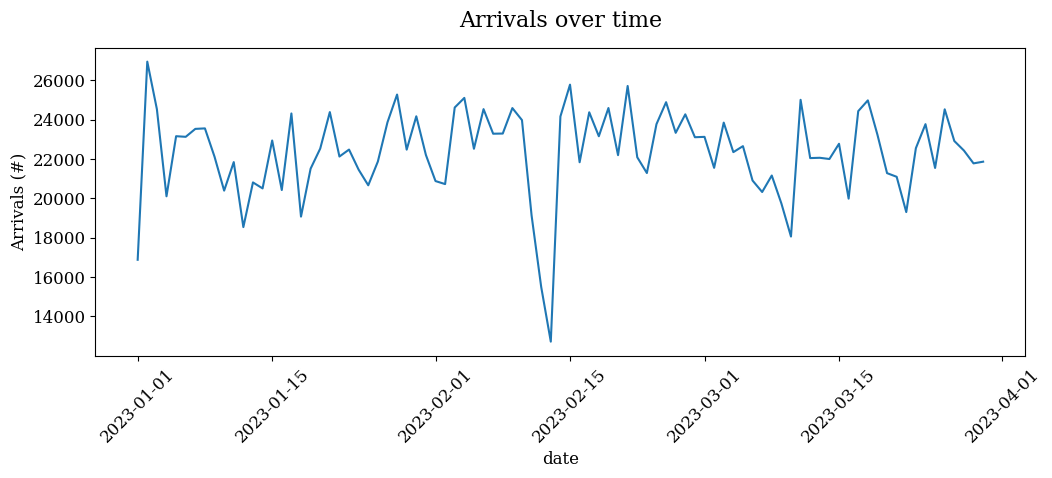

In [6]:
ax = arrivals.container.groupby(arrivals.date.dt.date).count().plot(rot=45)
ax.set_ylabel("Arrivals (#)")
ax.set_title("Arrivals over time");

Above: arrivals at all containers (aggregate). The significant drop mid-February is when the strike occurred. 

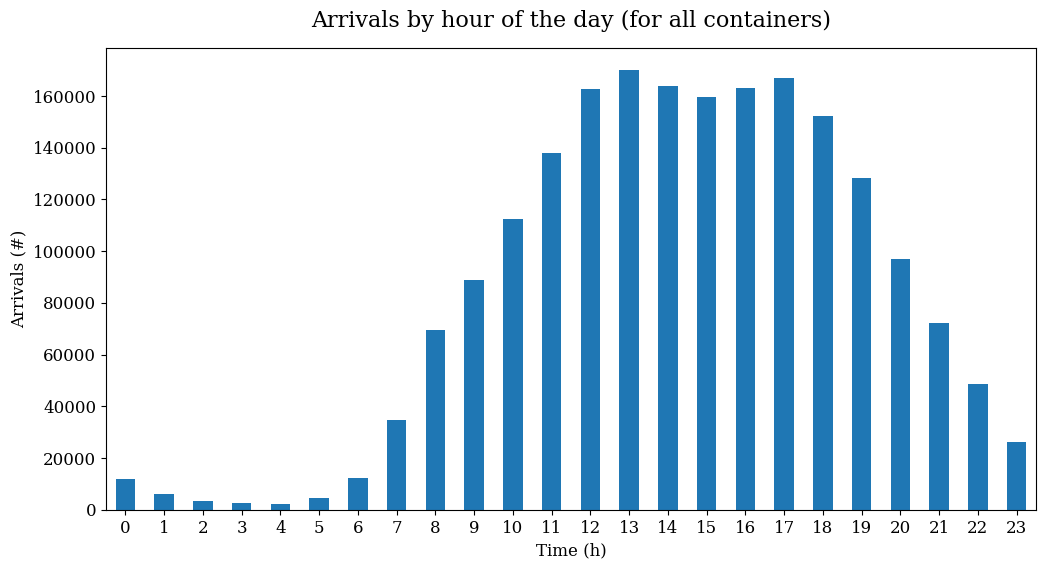

In [7]:
ax = arrivals.date.groupby(arrivals.date.dt.hour).count().plot.bar(figsize=(12, 6), rot=0)
ax.set_xlabel("Time (h)")
ax.set_ylabel("Arrivals (#)")
ax.set_title("Arrivals by hour of the day (for all containers)");

Above: arrivals by hour over all containers (aggregate).

## Exploring the service data

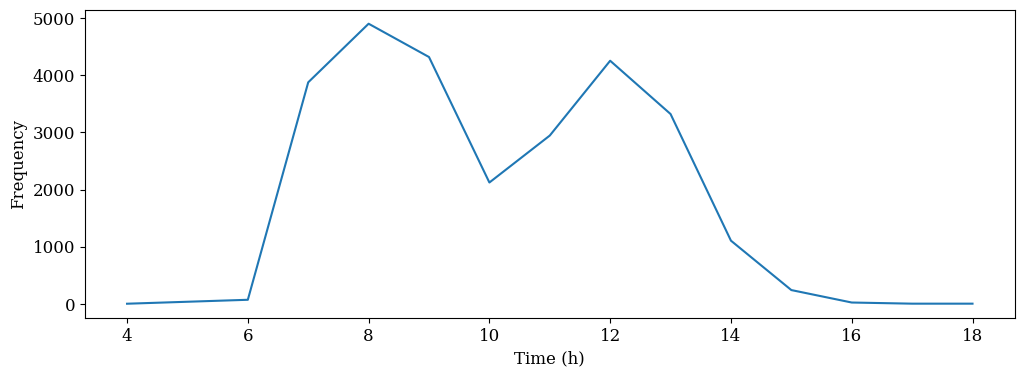

In [8]:
ax = services.date.groupby(services.date.dt.hour).count().plot()
ax.set_xlabel("Time (h)")
ax.set_ylabel("Frequency");

Above: aggreagte number of services (containers being emptied) by time-of-day, over all of Q1.
The coffee break around 10-11 is clearly visible in the data.

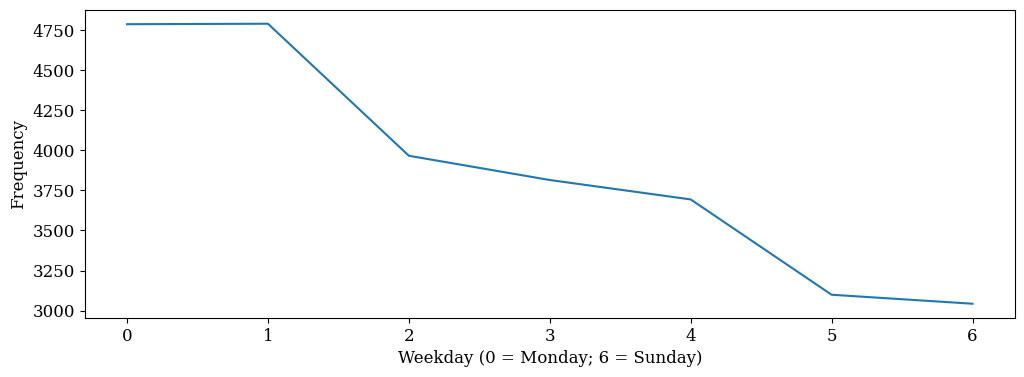

In [9]:
ax = services.date.groupby(services.date.dt.weekday).count().plot()
ax.set_xlabel("Weekday (0 = Monday; 6 = Sunday)")
ax.set_ylabel("Frequency");

Above: most emptying occurs on Monday and Tuesday, with servicing dropping gradually later on.
Services occur on every weekday, however, so this might be a planning/staffing/equipment decision?

## A single container

Now I'll focus on a single container.
I'm opting for the container with ID 1836, since that's the one on my street corner :-).

In [10]:
my_container = '1836'
my_arrivals = arrivals[arrivals.container == my_container]
my_services = services[services.container == my_container]

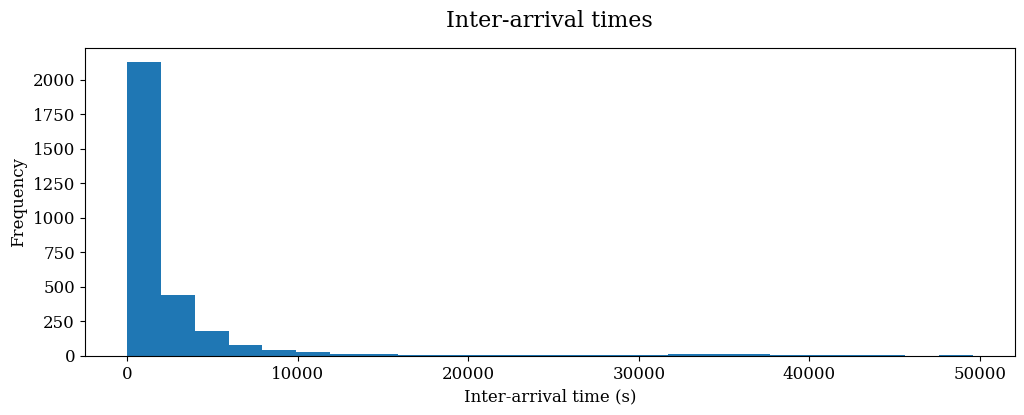

In [11]:
interarrivals = my_arrivals.date.diff(1).astype('timedelta64[s]')
ax = interarrivals.plot.hist(bins=25)
ax.set_title("Inter-arrival times")
ax.set_xlabel("Inter-arrival time (s)")
ax.set_ylabel("Frequency");

Above: inter-arrival times (in seconds) for 'my' container (ID 1836). 
These are the times between successive arrivals. 
Looks very exponential to me (with a few long outliers, but no matter), as it should be.

In [12]:
def make_event_list():
    a_events = my_arrivals.date.to_frame()
    a_events['arrival'] = 1

    s_events = my_services.date.to_frame()
    s_events['arrival'] = 0

    events = pd.concat([a_events, s_events]).sort_values(by='date')

    cumsum = 0
    arrivals = events.arrival.values
    stored = np.zeros(len(events))

    for idx in range(len(events)):
        cumsum = cumsum + 1 if arrivals[idx] else 0
        stored[idx] = cumsum

    events['stored'] = stored

    return events

In [13]:
events = make_event_list()

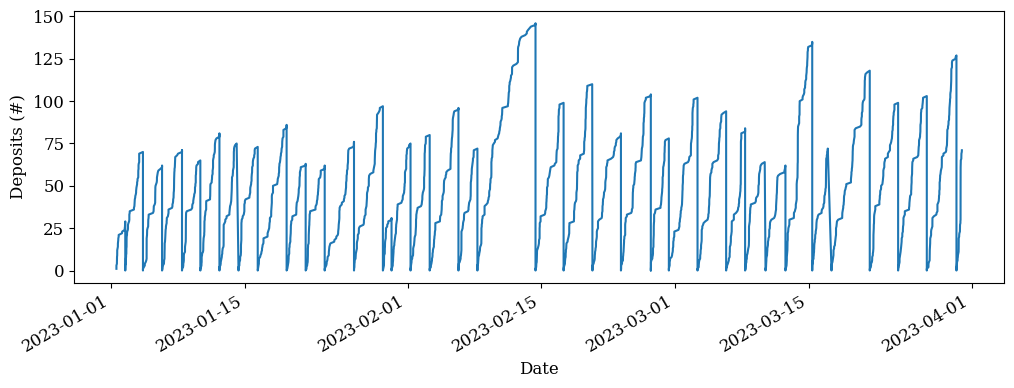

In [14]:
ax = events.plot(x='date', y='stored', legend=False)
ax.set_xlabel("Date")
ax.set_ylabel("Deposits (#)");

Above: the arrivals and services plotted in a single figure.
Each service resets the number of deposits in the container to zero.
Again, the strike around mid-February is clearly visible.
The arrival pattern is also highly regular.